In [2]:
import faculty.datasets as datasets
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

%matplotlib inline



In [3]:
datasets.get('/metadata/plans.xlsx','plans.xlsx')

In [4]:
df = pd.read_excel('plans.xlsx')
df_missing = df[df['text'].isna()]
df_dirty = df[df['text'].notna()]
df_missing_url = df_missing[df_missing['url'].isna()]
df_missing_url[['council','url','title','file_type','text']]
df_missing_url.to_csv('plans_missing_url.csv')
# df['text'][5]

## Data Cleaning
Remember that the kind/amount of preprocessing is specific to the NLP task.

Here, in order to get some idea of topics contained, we'll remove all non-alphanumeric characters.


In [5]:
import re
import unicodedata

def is_pua(c):
    return unicodedata.category(c) == 'Co'

def clean_plan(text):
    # take out all duplicated whitespace so each word separated by one space
    text = ' '.join(text.split())
    text = text.lower()
    #remove the private use characters
    text = "".join([char for char in text if not is_pua(char)])
    text = text.replace('_x000C_','')
    # remove all non-alphanumeric
    text = re.sub("[^A-Za-z. ]",'',text)
    return text

In [6]:
df_clean = df_dirty
df_clean['text'] = df_dirty['text'].map(clean_plan)
test_corpus = df_clean['text']

/tmp/ipykernel_237213/1372362497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['text'] = df_dirty['text'].map(clean_plan)


## Data Preprocessing

In [185]:
!pip install spacy

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
  Using cached spacy-3.5.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
  Using cached pyda

In [188]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


phrase = 'he operates an operative operating in the operating opera'
doc = nlp(phrase)
[token.lemma_ for token in doc]

['he',
 'operate',
 'an',
 'operative',
 'operating',
 'in',
 'the',
 'operating',
 'opera']

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS
tfidf_vectorizer = TfidfVectorizer(use_idf=True,stop_words="english", max_features=100,ngram_range=(2,2))#hyperparameter to explore
tfidf_vectors = tfidf_vectorizer.fit_transform(df_clean['text'])



In [167]:
# print out your vectors in a nice way
features = tfidf_vectorizer.get_feature_names()
for i, row in enumerate(tfidf_vectors.toarray()):
    # print out your vectors in a nice way
    print(
        pd.DataFrame({"Terms": features, "Frq_id_freq": row}).to_string(index=False)
    )
    print("-" * 40)

                  Terms  Frq_id_freq
         action climate     0.000000
            action plan     0.048477
          active travel     0.173797
          adur worthing     0.000000
            air quality     0.000000
        borough council     0.000000
        business travel     0.000000
          carbon budget     0.099393
         carbon dioxide     0.065315
       carbon emissions     0.045168
       carbon footprint     0.000000
      carbon management     0.099753
         carbon neutral     0.000000
      carbon neutrality     0.000000
       carbon reduction     0.000000
             change act     0.000000
          change action     0.097298
        change strategy     0.000000
       changing climate     0.182632
        charging points     0.000000
           city council     0.114498
         climate action     0.081534
         climate change     0.694911
     climate ecological     0.000000
      climate emergency     0.000000
      council buildings     0.000000
 

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Dimensionality reduction
<h2>PCA</h2>

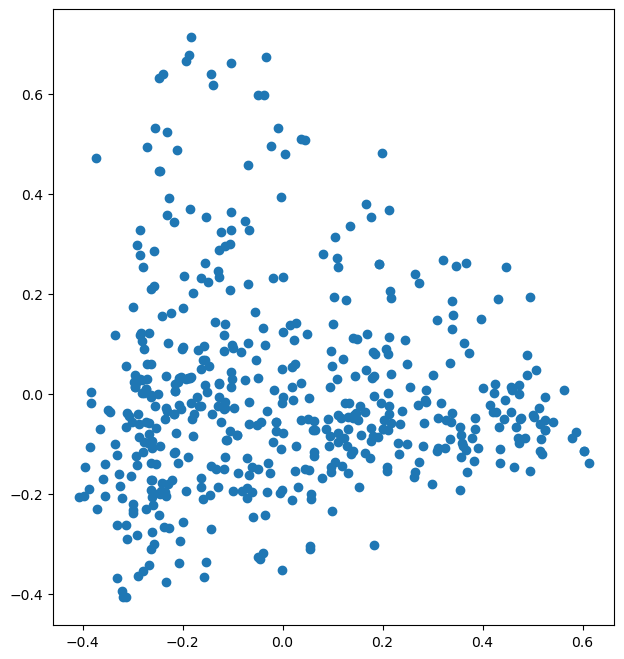

In [168]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# dimensional reduction techniques often make use of the `fit_transform` method
# it both fits the model and then transforms the vectors you inputted
X_pca = pca.fit_transform(tfidf_vectors.toarray())
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect="equal")
ax.scatter(X_pca[:,0],X_pca[:,1])

# T-sne

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


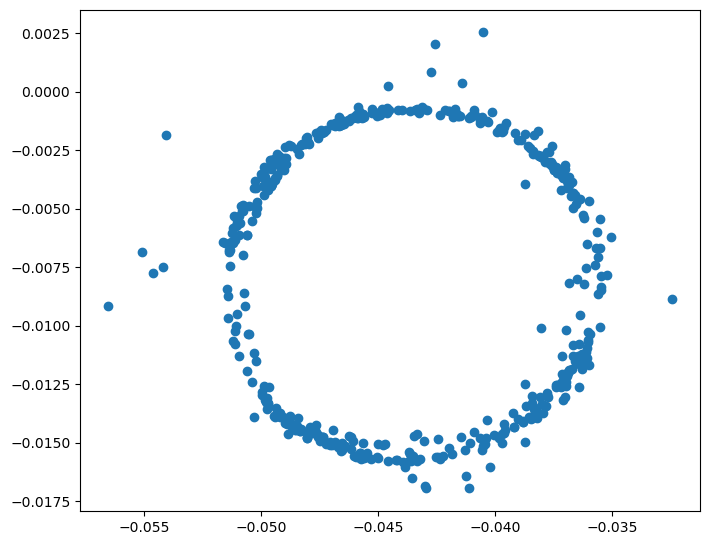

In [169]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=600)

X_tsne = tsne.fit_transform(tfidf_vectors.toarray())
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect="equal")
ax.scatter(X_tsne[:,0],X_tsne[:,1])

# K-means clustering

In [170]:
# run k-means on your tsne vectors
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20)
km.fit(X_tsne)

df_clean['kmeans_tsne'] = km.labels_ 

/tmp/ipykernel_121007/3326669368.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['kmeans_tsne'] = km.labels_


In [1]:
def scatter_1(x, cluster):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect="equal")
    
    for i in range(num_clusters):
        ax.scatter(
            x[(cluster == i), 0],
            x[(cluster == i), 1],
            label= f"cluster{i}",
            alpha=0.5,
        )
    
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    plt.legend()
    return f, ax

f,ax = scatter_1(X_tsne,df_clean['kmeans_tsne'])

NameError: name 'X_tsne' is not defined

In [172]:
# df_clean

In [173]:
few_col = ['council', 'time_period', 'type', 'scope', 'status',
       'plan_due', 'title','authority_type','country', 'county', 
        'region','population', 'text','kmeans_tsne']
df_clean[df_clean["kmeans_tsne"] == 1][few_col]

,council,time_period,type,scope,status,plan_due,title,authority_type,country,county,region,population,text,kmeans_tsne
20,Barrow-in-Furness Borough Council,2020-2025,Pre-plan,Whole area,Outlines climate policy as starting point for ...,Unclear,Climate Change Policy 2020-2025,NMD,England,CMA,North West,66726,barrow borough council climate change policy ...,1
21,Basildon Borough Council,NaN,Action plan,NaN,Plan,NaN,"Climate Change and Air Quality Topic Paper, Se...",NMD,England,ESS,East of England,187558,september basildon borough local plan climate...,1
22,Basingstoke and Deane Borough Council,2021-30,Climate strategy,Whole area,Approved,NaN,"Climate Change and Air Quality Strategy, 2021-...",NMD,England,HAM,South East,177760,climate change and air quality strategy for ba...,1
23,Basingstoke and Deane Borough Council,2020/1,Action plan,Whole area,Approved,NaN,Climate Emergency Action Plan 2020-2021,NMD,England,HAM,South East,177760,basingstoke deane climate emergency action pl...,1
26,Bedford Borough Council,2020-2030,Action plan,Whole area,Approved,NaN,Sustainable development and environmental effi...,UA,England,NaN,East of England,174687,priority demonstrating community leadership ....,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,West Lancashire Borough Council,2020-2030,Action plan,NaN,Approved,NaN,Climate Change Strategy and Action Plan 2030.docx,NMD,England,LAN,North West,114496,west lancashire borough council climate change...,1
631,West of England Combined Authority,2020-2030,Action plan,Whole area,Approved,NaN,West of England Climate Emergency Action Plan ...,COMB,England,NaN,South West,950039,west of england climate emergency action plan ...,1
639,West Yorkshire Combined Authority,NaN,Climate strategy,NaN,NaN,NaN,Towards a zero-carbon Leeds City Region Energy...,COMB,England,NaN,Yorkshire and The Humber,2345235,towards a zerocarbon leeds city region energy ...,1
657,Woking Borough Council,NaN,Progress Report,NaN,NaN,NaN,NaN,NMD,England,SRY,South East,100008,climate emergency action plan progress update...,1
